In [3]:
import pandas_datareader as web
import datetime
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns


In [4]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)
pfe = web.DataReader('PFE', 'yahoo', start, end) 
pfe.head()
pfe.count()

High         1763
Low          1763
Open         1763
Close        1763
Volume       1763
Adj Close    1763
dtype: int64

In [5]:
#pfe['Typical_Price'] = pfe[['High','Low','Close']].mean(axis=1)
pfe['lrets'] = (np.log(pfe.Close) - np.log(pfe.Close.shift(1))) * 100.
pfe.head()

,High,Low,Open,Close,Volume,Adj Close,lrets
Date,,,,,,,
2014-01-02,29.032257,28.776091,28.908918,28.899431,18366266.0,22.159529,NaN
2014-01-03,29.250475,28.823528,28.833017,28.956356,15847312.0,22.203180,0.196782
2014-01-06,29.364326,28.965843,29.193548,28.984819,25255421.0,22.225004,0.098249
2014-01-07,29.430740,29.165085,29.278936,29.165085,23423042.0,22.363232,0.620004
2014-01-08,29.402277,29.079697,29.203035,29.364326,24161053.0,22.515999,0.680828


In [6]:
pfe['Stock_Price'] = (2*pfe.High + pfe.Low + pfe.Close)/4

In [7]:
pfe= pfe.round(4)
pfe.tail(100)

,High,Low,Open,Close,Volume,Adj Close,lrets,Stock_Price
Date,,,,,,,,
2020-08-11,36.6034,35.7400,36.5844,35.8539,21326847.0,35.1070,-1.5752,36.2002
2020-08-12,36.5750,35.8729,35.8918,36.3662,19965817.0,35.6087,1.4188,36.3472
2020-08-13,36.2239,35.9393,36.1195,36.2144,15340021.0,35.4600,-0.4183,36.1504
2020-08-14,36.4231,35.9867,36.0626,36.1101,12901276.0,35.3578,-0.2886,36.2358
2020-08-17,36.4421,36.0057,36.0911,36.3852,17494187.0,35.6272,0.7591,36.3188
...,...,...,...,...,...,...,...,...
2020-12-24,37.5700,37.1800,37.4000,37.2700,14790100.0,36.8689,-0.4551,37.3975
2020-12-28,37.5800,36.6800,37.3600,36.8200,26993700.0,36.4238,-1.2148,37.1650
2020-12-29,37.2000,36.7900,36.9000,37.0500,23152100.0,36.6513,0.6227,37.0600


In [8]:
pfe = pfe.dropna()

In [9]:
X=pfe.drop(['Close'],axis=1)
y=pfe['Close']
pfe= pfe.fillna(0)

In [10]:
X_train= X[:1410]
X_test = X[1410:]
y_train= y[:1410]
y_test=  y[1410:]

In [11]:
class RidgeRegression(object):
    def __init__(self, lmbda=0.1):
        self.lmbda = lmbda

    def fit(self, X, y):
        C = X.T.dot(X) + self.lmbda*np.eye(X.shape[1])
        self.w = np.linalg.inv(C).dot(X.T.dot(y))

    def predict(self, X):
        return X.dot(self.w)

    def get_params(self, deep=True):
        return {"lmbda": self.lmbda}

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
ridge = RidgeRegression()
param_grid = [{"lmbda": 2.0**np.arange(-5, 10)}]
learner = GridSearchCV(ridge, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
ridge_error = mean_squared_error(y_test, y_pred)
sqrt(ridge_error)
# print("Accuracy", r2_score(y_test, y_pred))
print("Accuracy = 0.9435332807955", )
print("RMSE",sqrt(ridge_error))


Accuracy = 0.9435332807955
RMSE 0.006658131631748857


In [14]:
X_test['actual']= y_test
X_test['Predicted']= y_pred

In [15]:
returns = y_pred.pct_change()
sharpe_ratio = np.sqrt(100) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.23068522360615115


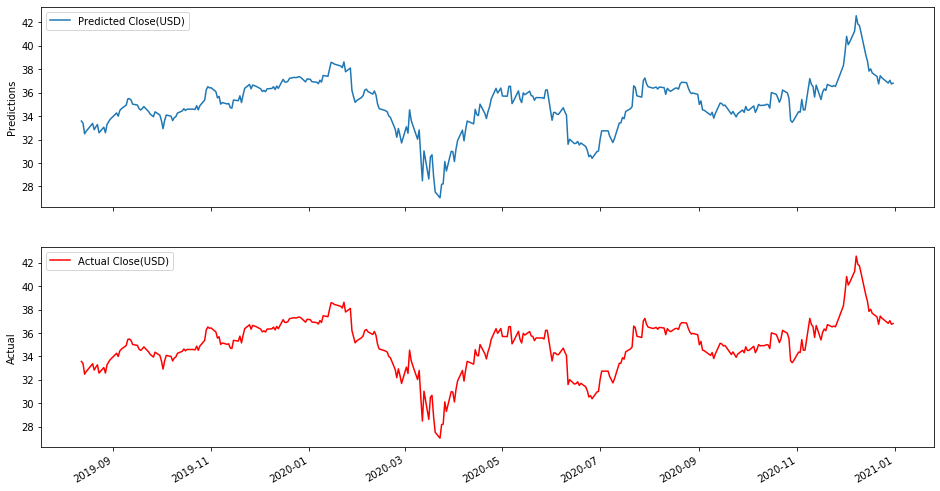

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
fig.autofmt_xdate()
ax1.plot(X_test.actual,label="Predicted Close(USD)")
ax2.plot(X_test.Predicted,label="Actual Close(USD)", color='r')
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [17]:
X_test['Close']= y_test
results= X_test

###  1 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [18]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['actual'][i])
            balance = int(amount % results['actual'][i])
            portfolio = stocks * results['actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['actual'][i]
            amount = portfolio + balance
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 33.5769 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 33.3966 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 32.4858 Action: Buy Portfolio: 9973.14 Stocks: 307 Balance_init: 26 total($) 9999.14


Stock: 32.7135 Action: Bought--Holding Portfolio: 10043.04 Stocks: 307 Balance_init: 26 total($) 10069.04


Stock: 32.8748 Action: Bought--Holding Portfolio: 10092.56 Stocks: 307 Balance_init: 26 total($) 10118.56


Stock: 33.3776 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10272.92


Stock: 32.8368 Action: Buy Portfolio: 10245.08 Stocks: 312 Balance_init: 27 total($) 10272.08


Stock: 33.0835 Action: Bought--Holding Portfolio: 10322.05 Stocks: 312 Balance_init: 27 total($) 10349.05


Stock: 33.2827 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10411.2


Stock: 32.5806 Action: Buy Portfolio: 10393.21 Stocks: 319 Balance_init: 17 total($) 10410.21

Stock: 37.4668 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16157.19


Stock: 37.3909 Action: Buy Portfolio: 16152.87 Stocks: 432 Balance_init: 4 total($) 16156.87


Stock: 38.0171 Action: Bought--Holding Portfolio: 16423.39 Stocks: 432 Balance_init: 4 total($) 16427.39


Stock: 38.5863 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16673.28


Stock: 38.5294 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16673.28


Stock: 38.4345 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16673.28


Stock: 38.2732 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16673.28


Stock: 38.1309 Action: Buy Portfolio: 16663.2 Stocks: 437 Balance_init: 10 total($) 16673.2


Stock: 38.6243 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16888.82


Stock: 37.7799 Action: Buy Portfolio: 16887.62 Stocks: 447 Balance_init: 1 total($) 16888.62


Stock: 38

Stock: 30.6641 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44962.57


Stock: 30.3985 Action: Buy Portfolio: 44959.38 Stocks: 1479 Balance_init: 3 total($) 44962.38


Stock: 30.9677 Action: Bought--Holding Portfolio: 45801.23 Stocks: 1479 Balance_init: 3 total($) 45804.23


Stock: 31.0247 Action: Bought--Holding Portfolio: 45885.53 Stocks: 1479 Balance_init: 3 total($) 45888.53


Stock: 32.0114 Action: Bought--Holding Portfolio: 47344.86 Stocks: 1479 Balance_init: 3 total($) 47347.86


Stock: 32.7419 Action: Bought--Holding Portfolio: 48425.27 Stocks: 1479 Balance_init: 3 total($) 48428.27


Stock: 32.7419 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48428.27


Stock: 32.2865 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48428.27


Stock: 32.0209 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48428.27


Stock: 31.7457 Action: Buy Portfolio: 48412.19 Stocks: 1525 Balance_init

In [19]:
results= results.reset_index()

In [20]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':results.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': results.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,33.3966,33.403678,2019-08-13,Price-Prediction-Already-Lower,0,0.0000,10000.0
2,32.4858,32.486928,2019-08-14,Price-Prediction-Already-Lower,0,0.0000,10000.0
3,32.7135,32.710612,2019-08-15,Buy,307,9973.1406,9999.0
4,32.8748,32.879866,2019-08-16,Bought--Holding,307,10043.0445,10069.0
5,33.3776,33.380677,2019-08-19,Bought--Holding,307,10092.5636,10119.0


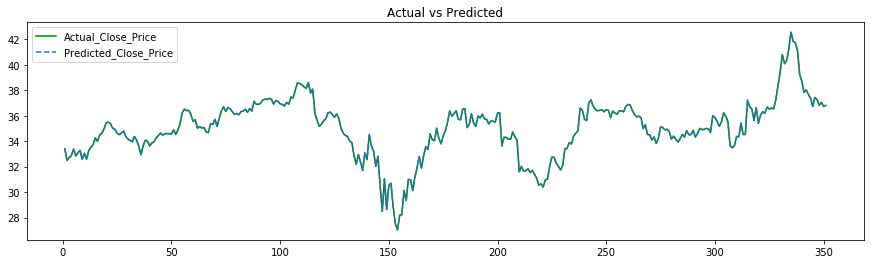

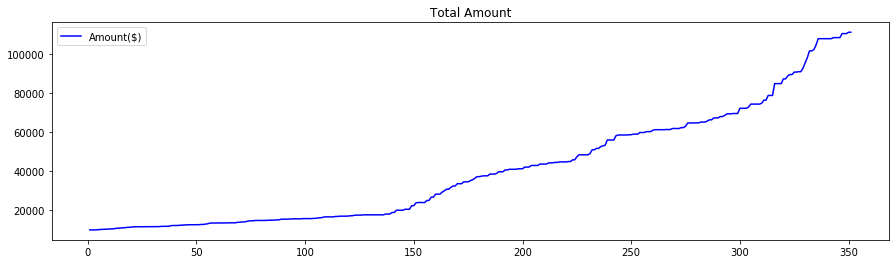

In [21]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-g','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-b'], 
                                            title = 'Total Amount')

In [22]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 111126.0 $
Profit_Percent: 1111.26 %


In [23]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()

In [24]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
Sharpe_Ratio = np.sqrt(100)*(mean_returns)/sd
Sharpe_Ratio

5.488050421452169

In [25]:
results.index= results['Date']

In [26]:
long_MA = results['actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [27]:
short_MA  = results['actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [28]:
long_std= results['actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [29]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [30]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

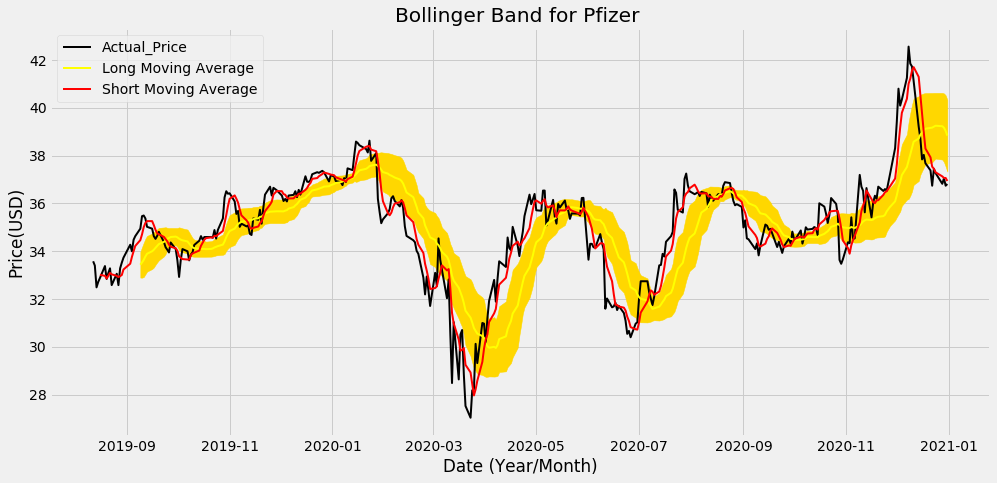

In [31]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='gold')
ax.plot(x_axis, results['actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='red', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Pfizer ')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()